In [24]:
# Core
import warnings
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame

# Error metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import max_error as ME
from sklearn.metrics import mean_absolute_error as MAE

# Machine Learning 
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.datasets import make_regression
import xgboost as xgb

#Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit

# Optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Others
import math

import sys
sys.path.append('../')
from utils import ML

In [25]:
# Core setting for print, warning and plotting
pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all" # Allow multiple outputs in the same cell
warnings.filterwarnings("ignore") # Ignore warnings
plt.style.use(get_style_file_path())

rcParams['figure.figsize'] = 16, 6 # Set the standard plot size
%matplotlib inline

In [46]:
target = 'GHI'
train_all = False

In [47]:
solar = pd.read_csv('../data/NASA_Dataset_Cleaned.csv', index_col = 'DATETIME', parse_dates=['DATETIME', 'DATETIME'])

In [48]:
vars_to_drop = ['DNI', 'DHI','GHI']
vars_to_drop.remove(target)
solar.drop(labels=vars_to_drop, axis=1,inplace=True)

In [49]:
# as said above the k terms for each yearly, weekly and daily seasonalities could be chosen by optimizing on the AIC values..
# but after some research on solar irradiance time series k = 5 was chosen for each seasonality
# ML.add_fourier_terms(solar, year_k= 5, day_k=5)

In [50]:
def create_features(df):
  target_map = solar[target].to_dict()
  df['lag0'] = (df.index - pd.Timedelta('5 hours')).map(target_map)
  df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
  df['lag2'] = (df.index - pd.Timedelta('8 days')).map(target_map)
  df['lag3'] = (df.index - pd.Timedelta('9 days')).map(target_map)
  df['lag4'] = (df.index - pd.Timedelta('10 days')).map(target_map)
  df['lag5'] = (df.index - pd.Timedelta('11 days')).map(target_map)
  df['lag6'] = (df.index - pd.Timedelta('12 days')).map(target_map)
  df['lag7'] = (df.index - pd.Timedelta('13 days')).map(target_map)
  df['lag8'] = (df.index - pd.Timedelta('364 days')).map(target_map)
  df['lag9'] = (df.index - pd.Timedelta('728 days')).map(target_map)
  df['lag10'] = (df.index - pd.Timedelta('1092 days')).map(target_map)  

  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear
  df.set_index('date', inplace=True)

  return df

solar = create_features(solar)

In [51]:
# def create_features(df):
#     """
#     Creates time series features from datetime index
#     """        
    
#     df['date'] = df.index
#     df['hour'] = df['date'].dt.hour
#     df['dayofweek'] = df['date'].dt.dayofweek
#     df['quarter'] = df['date'].dt.quarter
#     df['month'] = df['date'].dt.month
#     df['year'] = df['date'].dt.year
#     df['dayofyear'] = df['date'].dt.dayofyear
#     df['dayofmonth'] = df['date'].dt.day
#     df['weekofyear'] = df['date'].dt.weekofyear
#     df.set_index('date', inplace=True)

#     df[f'{target}_6_hrs_lag'] = df[target].shift(6)
#     df[f'{target}_12_hrs_lag'] = df[target].shift(12)
#     df[f'{target}_24_hrs_lag'] = df[target].shift(24)

#     df[f'{target}_6_hrs_mean'] = df[target].rolling(window = 6).mean()
#     df[f'{target}_12_hrs_mean'] = df[target].rolling(window = 12).mean()
#     df[f'{target}_24_hrs_mean'] = df[target].rolling(window = 24).mean()

#     df[f'{target}_6_hrs_std'] = df[target].rolling(window = 6).std()
#     df[f'{target}_12_hrs_std'] = df[target].rolling(window = 12).std()
#     df[f'{target}_24_hrs_std'] = df[target].rolling(window = 24).std()

#     df[f'{target}_6_hrs_max'] = df[target].rolling(window = 6).max()
#     df[f'{target}_12_hrs_max'] = df[target].rolling(window = 12).max()
#     df[f'{target}_24_hrs_max'] = df[target].rolling(window = 24).max()
    
#     df[f'{target}_6_hrs_min'] = df[f'{target}'].rolling(window = 6).min()
#     df[f'{target}_12_hrs_min'] = df[f'{target}'].rolling(window = 12).min()
#     df[f'{target}_24_hrs_min'] = df[f'{target}'].rolling(window = 24).min()

#     return df

# solar = create_features(solar)


In [52]:
# not adding year variable here because the model will use the most recent lag energy consumption values
cols_to_transform = ['T2MDEW', 'DIFFUSE_ILLUMINANCE', 'DIRECT_ILLUMINANCE',
       'GLOBAL_ILLUMINANCE', 'RH2M', 'QV2M', 'PS', 'T2M', 'SZA', 'WS2M'] # other columns are binary values
X_trainF, X_testF, y_trainF, y_testF = ML.train_test(
       data=solar,
       target=target,
       test_size = 0.15, 
       scale = True,
       cols_to_transform=cols_to_transform,
       plot=False)

if train_all:
       X_testF = pd.concat([X_trainF, X_testF])
       y_testF = pd.concat([y_trainF, y_testF])

In [53]:
# # Tuning the XGBoost model
# xgbtuned = xgb.XGBRegressor()

# param_grid = {
#         'objective': ['reg:squarederror'],
#         'max_depth': [8],
#         'learning_rate': [0.05],
#         'subsample': [0.3],
#         'colsample_bytree': [0.7], 
#         'colsample_bylevel': [0.7], 
#         'min_child_weight': [1.5],
#         'gamma': [0.2],
#         'n_estimators': [400]
#         }

# # Best score: -10.616212801508329

# tscv = TimeSeriesSplit(n_splits=5)

# xgbtunedreg = RandomizedSearchCV(xgbtuned, param_distributions=param_grid , 
#                                    scoring='neg_root_mean_squared_error', n_iter=20, n_jobs=-1, 
#                                    cv=tscv, verbose=2, random_state=1)

# xgbtunedreg.fit(X_trainF, y_trainF)
# best_score = xgbtunedreg.best_score_
# best_params = xgbtunedreg.best_params_
# print("Best score: {}".format(best_score))
# print("Best params: ")
# for param_name in sorted(best_params.keys()):
#     print('%s: %r' % (param_name, best_params[param_name]))

In [54]:
# Prepare data as DMatrix objects
train = xgb.DMatrix(X_trainF, y_trainF)
test = xgb.DMatrix(X_testF, y_testF)

params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'max_depth': 8,
        'learning_rate': 0.05,
        'subsample': 0.3,
        'colsample_bytree': 0.7, 
        'colsample_bylevel': 0.7, 
        'min_child_weight': 1.5,
        'gamma': 0.2,
        # 'n_estimators': 400,
        'n_jobs':-1, 
        'random_state':1
        }

xgbtunedreg = xgb.train(
        params,
        train, evals=[(train, "train"), (test, "validation")],
        num_boost_round=1000, early_stopping_rounds=20
)

xgbtunedreg.save_model(f"xgb_model_{target}.json")

[0]	train-rmse:336.33015	validation-rmse:326.48633
[1]	train-rmse:319.58784	validation-rmse:310.19953
[2]	train-rmse:303.69602	validation-rmse:294.76282
[3]	train-rmse:288.58897	validation-rmse:280.08619
[4]	train-rmse:274.23530	validation-rmse:266.11611
[5]	train-rmse:260.61281	validation-rmse:252.88335
[6]	train-rmse:247.66120	validation-rmse:240.32017
[7]	train-rmse:235.35446	validation-rmse:228.34867
[8]	train-rmse:223.65405	validation-rmse:216.97505
[9]	train-rmse:212.54102	validation-rmse:206.17262
[10]	train-rmse:201.98987	validation-rmse:195.91252
[11]	train-rmse:191.97487	validation-rmse:186.24324
[12]	train-rmse:182.45913	validation-rmse:177.00526
[13]	train-rmse:173.42161	validation-rmse:168.25141
[14]	train-rmse:164.82738	validation-rmse:159.90991
[15]	train-rmse:156.66148	validation-rmse:151.98809
[16]	train-rmse:148.91055	validation-rmse:144.51182
[17]	train-rmse:141.54951	validation-rmse:137.39133
[18]	train-rmse:134.55245	validation-rmse:130.62646
[19]	train-rmse:127.90

# Load the model

In [55]:
import xgboost as xgb

xgbtunedreg = xgb.Booster()
xgbtunedreg.load_model(f"xgb_model_{target}.json")

In [56]:
# Prepare data as DMatrix objects
train = xgb.DMatrix(X_trainF)
test = xgb.DMatrix(X_testF)

In [57]:
preds_xgb_train = xgbtunedreg.predict(train, ntree_limit=xgbtunedreg.best_ntree_limit)
preds_xgb_test = xgbtunedreg.predict(test, ntree_limit=xgbtunedreg.best_ntree_limit)

# Results

In [58]:
import sys
sys.path.append('../')
from utils import ML
from project_core.reporting.utils import get_style_file_path

In [59]:
dict_error = {}

In [60]:
# Test Set
dict_error = ML.error_metrics(
    y_pred=preds_xgb_train, 
    y_truth=y_trainF, 
    model_name='Tuned XGBoost on Train Set', 
    test=False, 
    dict_error=dict_error)
# RMSE: 5.99
# R2: 1.00
# MAE: 2.96


Error metrics for model Tuned XGBoost on Train Set
RMSE or Root mean squared error: 5.80
R² score: 1.00
MAE or Mean Absolute Error: 2.93


In [61]:
# Training Set
dict_error = ML.error_metrics(
    y_pred=preds_xgb_test, 
    y_truth=y_testF, 
    model_name='Tuned XGBoost on Test Set', 
    test=True, 
    dict_error=dict_error)
# RMSE: 15.56
# R2: 1.00
# MAE: 5.95


Error metrics for model Tuned XGBoost on Test Set
RMSE or Root mean squared error: 15.11
R² score: 1.00
MAE or Mean Absolute Error: 5.51


In [62]:
ML.plot_ts_pred(
    og_ts=y_testF, 
    pred_ts=preds_xgb_test, 
    model_name=f'Tuned XGBoost on Test Set')

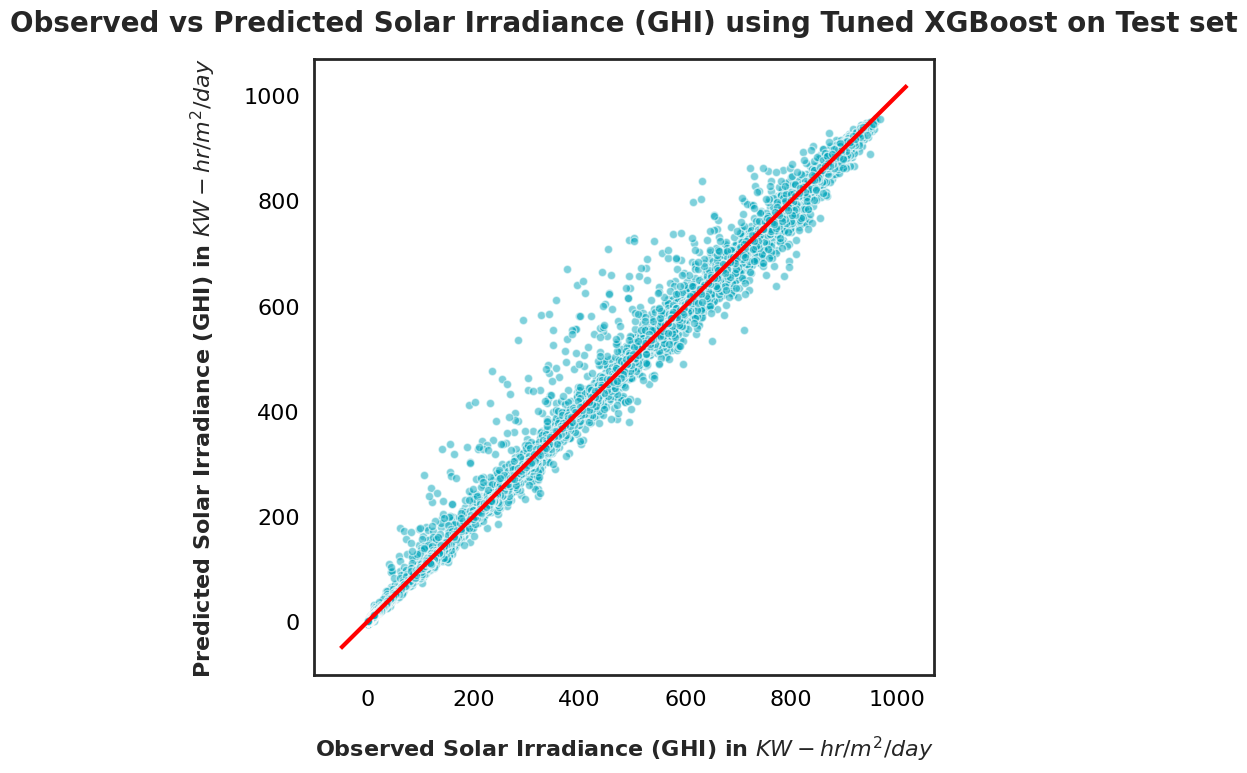

In [63]:
ML.plot_predvstrue_reg(
    pred=preds_xgb_test, 
    truth=y_testF, 
    model_name='Tuned XGBoost on Test set')

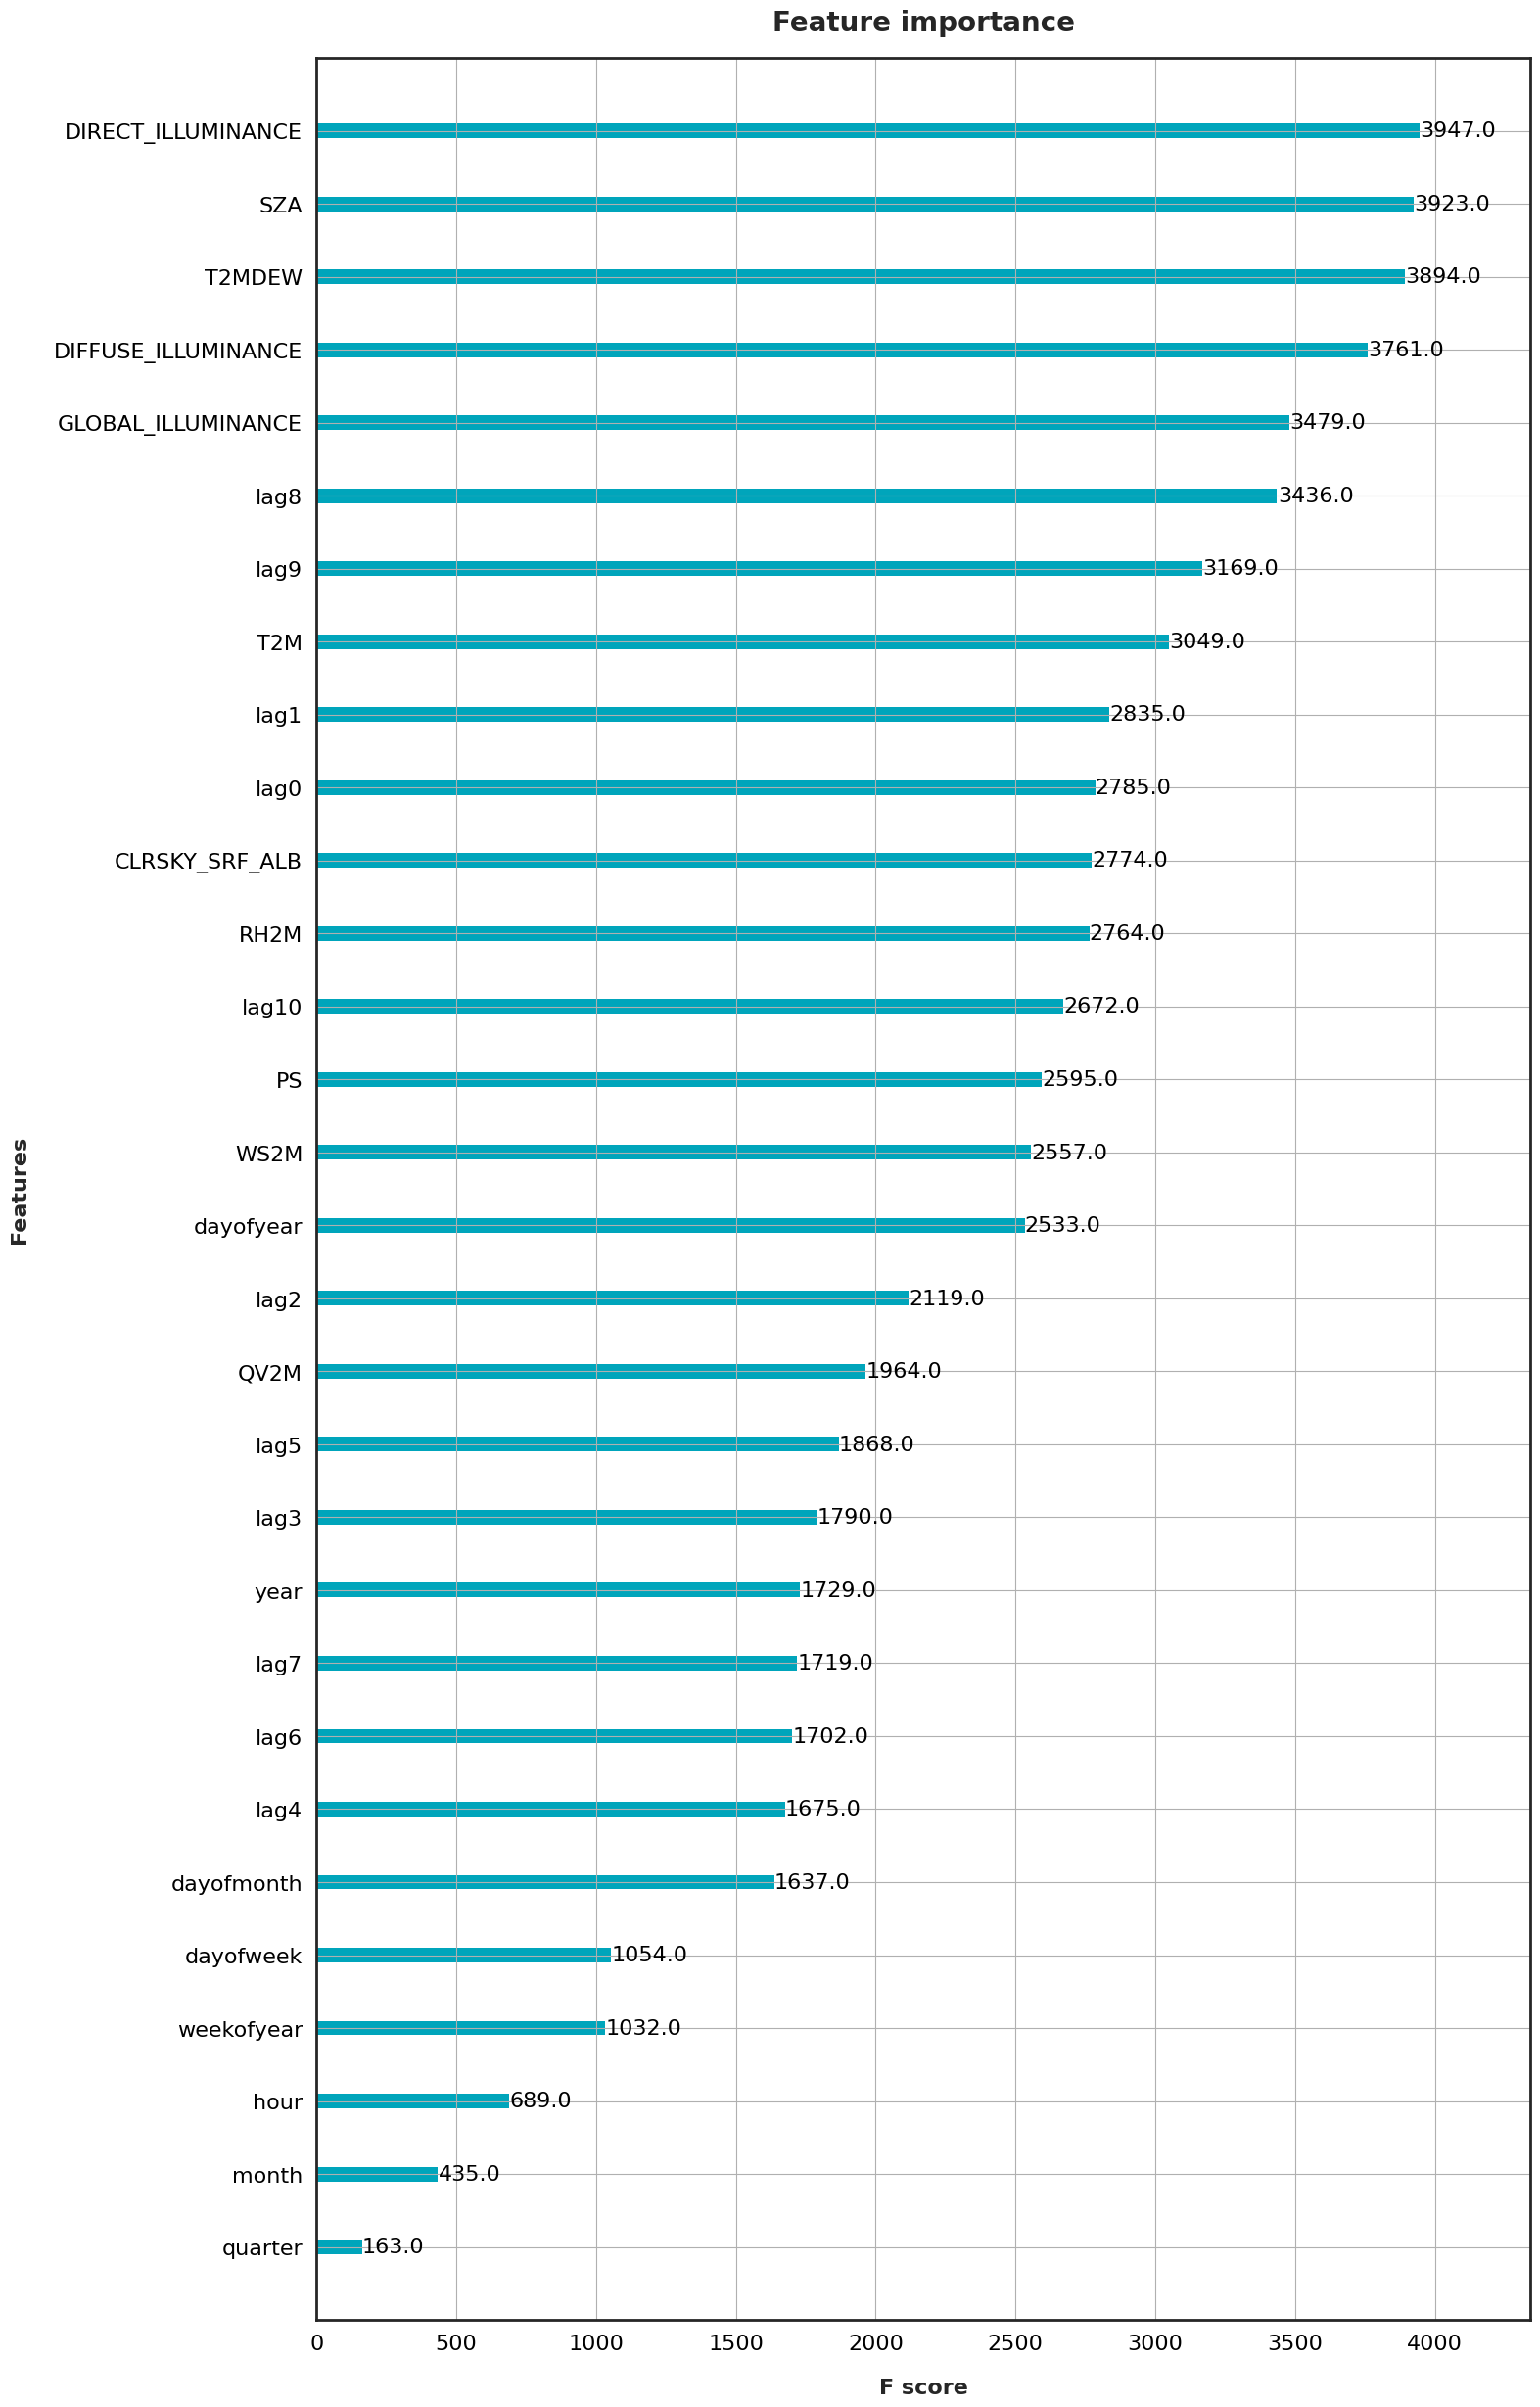

In [64]:
#pd.plotting.register_matplotlib_converters()
xgb.plot_importance(xgbtunedreg);
_ = plt.rcParams['figure.figsize'] = [16, 30];